<a href="https://colab.research.google.com/github/gulabpatel/Knowledge_Graph/blob/main/00%3A%20KnowledgeGraphs_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Knowledge Graph Construction for NLP Applications**

In the implementation below we will learn the following:

1.   Extracting meaningful ***information*** from unstructured text data
2.   ***Constructing Knowledge Graphs*** from the extracted information

First, we will understand the Knowledge Graph construction process on unstructured text data, with a simple example

Consequently, we will employ the same process on ***unstructured wikipedia data***


# **Import Packages and Libraries**

In [ ]:
# Generic Libraries
import re
import pandas as pd # For creating dataframes of extracted information
import bs4
import requests
from tqdm import tqdm

# NLP Specific Libraries
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')
from spacy.matcher import Matcher 
from spacy.tokens import Span 

# Libraries for displaying Knowledge Graph
import networkx as nx
import matplotlib.pyplot as plt


pd.set_option('display.max_colwidth', 200)
%matplotlib inline

# **Understanding the Dependency Parser**

In [ ]:
doc = nlp("Christiano Ronaldo plays for Juventus")

for tok in doc:
  print(tok.text, "->", tok.dep_)

Christiano -> compound
Ronaldo -> nsubj
plays -> ROOT
for -> prep
Juventus -> pobj


# **A Simple Example**

**Let us take a set of sentences on 'India'**

In [ ]:
sentences_India = ['India is known as Bharat',
             'India is a country in South Asia',
             'India is the seventh-largest country',
             'India is a democratic country',
             'India has its President as Ram Nath Kovind',
             'India has Prime Minister as Narendra Modi'
            ]

In [ ]:
sentences_India[1]

'India is a country in South Asia'

**Convert Sentences to a pandas dataframe**

In [ ]:
India_df = pd.DataFrame(sentences_India, columns =['India'])

In [ ]:
India_df.head(6)

,India
0,India is known as Bharat
1,India is a country in South Asia
2,India is the seventh-largest country
3,India is a democratic country
4,India has its President as Ram Nath Kovind
5,India has Prime Minister as Narendra Modi


# **Information Extraction**
**Extract Entities and Relations**

## **Function to extract *entities* from text**

In [ ]:
def get_entities(sent):
  head_entity = ""
  candidate_entity = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  
  for tok in nlp(sent):
    # If token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":

      # CHECK: token is a 'compound' or 'modifier' or 'attribute'
      if tok.dep_ == "compound" or tok.dep_.endswith("mod") or tok.dep_ == "attr":
        prefix = tok.text
        
        # If the previous word was also a 'compound' or 'modifier' or 'attribute', then add the current word to it
        if prv_tok_dep == "compound" or prv_tok_dep.endswith("mod") or prv_tok_dep == "attr":
          prefix = prv_tok_text + " " + tok.text
      
      # Assign head entity or, subject
      if tok.dep_.find("subj") == True:
        head_entity = prefix + " " + tok.text
        prefix = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      # Assign candidate entity or, object
      if tok.dep_.find("obj") == True:
        candidate_entity = prefix + " " + tok.text
      else:
        candidate_entity = prefix # In some cases the candidate entity is an 'attribute'
        
      # Update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text

  return [head_entity.strip(), candidate_entity.strip()]

In [ ]:
get_entities("Christiano Ronaldo scored 3 goals")

['Christiano Ronaldo', '3 goals']

## **Extract Head Entity and Candidate Entity (Subject and Object) from text**

In [ ]:
entity_pairs = []

for i in tqdm(India_df["India"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 6/6 [00:00<00:00, 145.04it/s]


In [ ]:
entity_pairs[0:6]

[['India', 'Bharat'],
 ['India', 'South Asia'],
 ['India', 'largest country'],
 ['India', 'democratic country'],
 ['India', 'Ram Nath Kovind'],
 ['India', 'Narendra Modi']]

## **Function to extract *relations* from text**

In [ ]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", None, pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

## **Extract Relations (Predicates) from text**

In [ ]:
relations = [get_relation(i) for i in tqdm(India_df['India'])]

100%|██████████| 6/6 [00:00<00:00, 151.47it/s]


In [ ]:
relations[0:5]

['known as', 'is', 'is', 'is', 'has']

## **Identify *subject/source* from entities**

In [ ]:
source = [i[0] for i in entity_pairs]

## **Identify *object/target* from entities**

In [ ]:
target = [i[1] for i in entity_pairs]

## **Create dataframe in <*subject, object, predicate*> format**
## **This is <*source, target, edge*> in knowledge graph**

In [ ]:
kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})
kg_df.head()

,source,target,edge
0,India,Bharat,known as
1,India,South Asia,is
2,India,largest country,is
3,India,democratic country,is
4,India,Ram Nath Kovind,has


# **Construct knowledge graph**

In [ ]:
KG_India = nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

# **Plot knowledge graph**

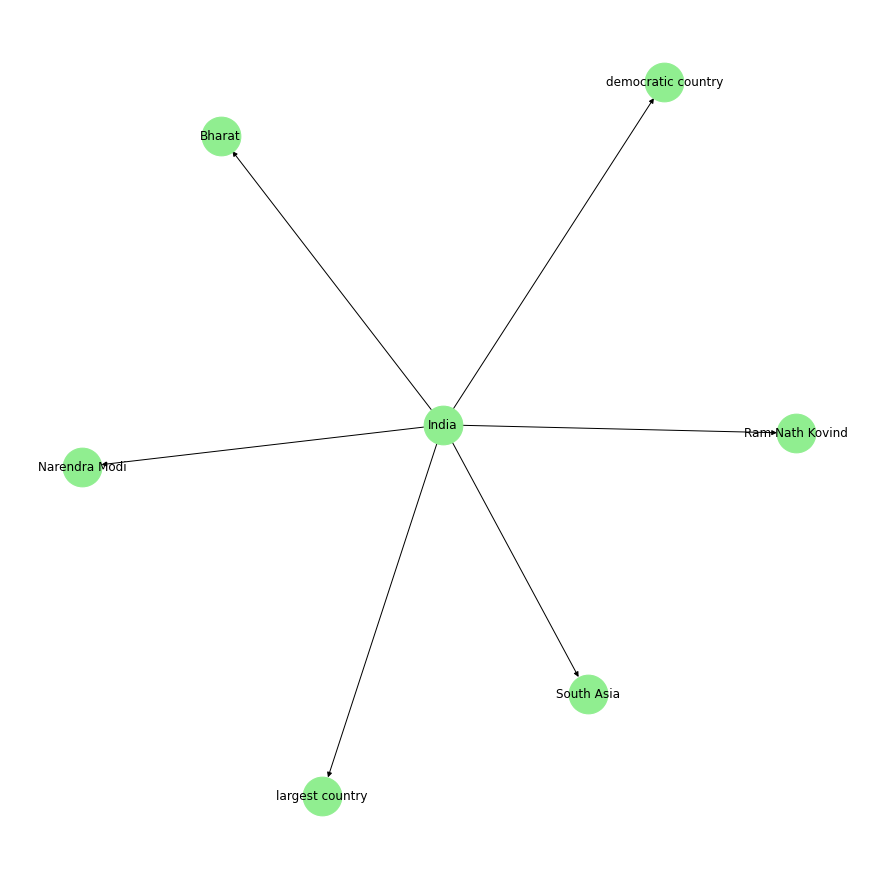

In [ ]:
plt.figure(figsize=(12,12))
pos = nx.spring_layout(KG_India)
nx.draw(KG_India, with_labels=True, node_color='lightgreen', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

# **Constructing Knowledge Graph on Large *unstructured* text**

## **Import wikipedia sentences**

In [ ]:
unstructured_text = pd.read_csv("/content/drive/MyDrive/Workshops/FDP_2021_KG/wiki_sentences_v2.csv")
unstructured_text.shape

(4318, 1)

In [ ]:
unstructured_text['sentence'].sample(5)

1275    it's not even enough to create a strong female character ...
3890      the teacher did not appeal the decision, instead retiring.
3385       western films are occasionally shown in movie theaters.  
1169         c. s. and lyrics were penned by yugabharathi and logan.
2988                 by 1916, separate cine type films were offered.
Name: sentence, dtype: object

In [ ]:
unstructured_text.head(20)

,sentence
0,"confused and frustrated, connie decides to leave on her own."
1,"later, a woman’s scream is heard in the distance."
2,christian is then paralyzed by an elder.
3,the temple is set on fire.
4,"outside, the cult wails with him."
5,it's a parable of a woman's religious awakening—
6,"c. mackenzie, and craig vincent joined the cast."
7,"later, craig di francia and action bronson were revealed to have joined the cast."
8,sebastian maniscalco and paul ben-victor were later revealed as being part of the cast.
9,we just tried to make the film.


## **Extract Entities from *unstructured* text**

In [ ]:
entity_pairs = []

for i in tqdm(unstructured_text["sentence"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 4318/4318 [00:27<00:00, 154.26it/s]


In [ ]:
entity_pairs[5:10]

[['it', 'religious awakening'],
 ['c. mackenzie', 'craig cast'],
 ['craig di francia', 'action cast'],
 ['sebastian maniscalco', 'part cast'],
 ['we', 'just film']]

## **Extract relations from *unstructured* text**

In [ ]:
relations = [get_relation(i) for i in tqdm(unstructured_text['sentence'])]

100%|██████████| 4318/4318 [00:27<00:00, 156.04it/s]


## **Create dataframe in <*source, target, edge*> format**

In [ ]:

source = [i[0] for i in entity_pairs]

target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})
kg_df.head(6)


,source,target,edge
0,connie,own,decides
1,later woman,distance,heard in
2,christian,then elder,paralyzed by
3,temple,fire,set on
4,outside cult,him,wails with
5,it,religious awakening,'s


### **Show top *50* relations**

In [ ]:
pd.Series(relations).value_counts()[:50]

is               370
was              297
released on       87
include           73
were              71
are               71
released          40
's                38
composed by       35
has               31
have              31
became            31
become            29
released in       27
included          26
produced          22
called            22
had               20
made              20
considered        20
been              18
be                18
used              17
scheduled         17
directed by       16
stars             16
written by        15
set               14
hired             14
produced by       14
wrote             14
received          13
went              13
introduced in     13
wanted            12
won               11
began             11
began in          11
sold              10
features          10
gave              10
opened             9
used in            9
directed           9
includes           9
gives              9
known as           9
shot in      

## **Construct and Plot Knowledge Graph for *unstructured* text**

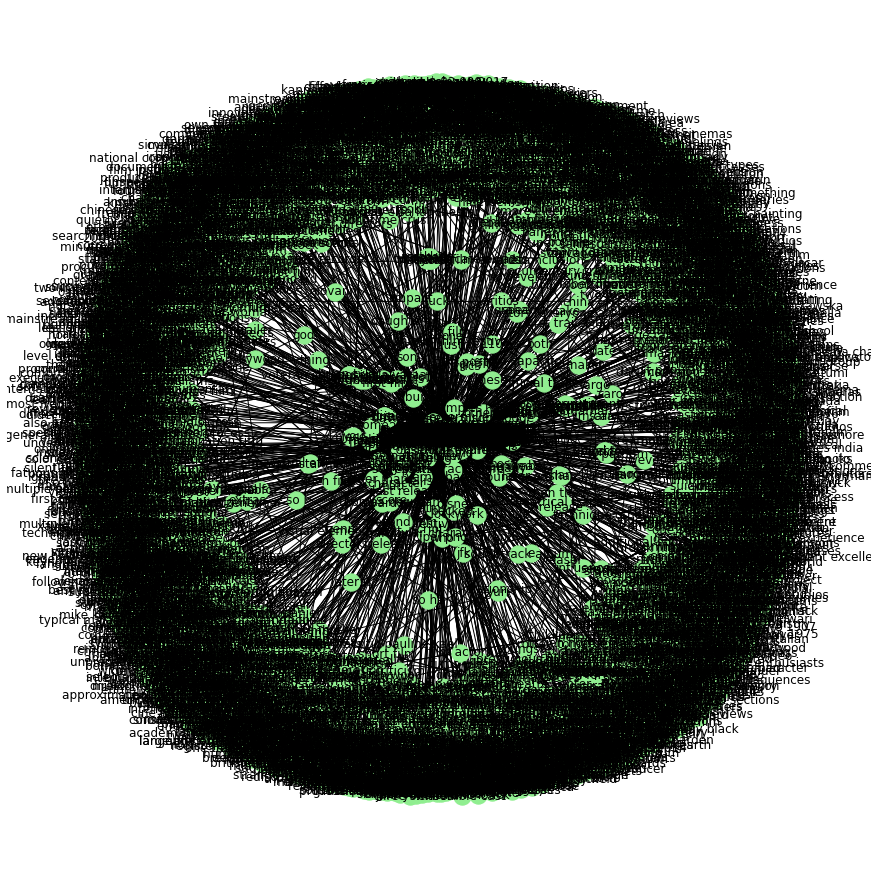

In [ ]:
# Construct knowledge graph over extracted information (dataframe)
KG = nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

# Plot Knowledge Graph
plt.figure(figsize=(12,12))
pos = nx.spring_layout(KG)
nx.draw(KG, with_labels=True, node_color='lightgreen', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()



## **Construct knowledge graph for a *single* relation**

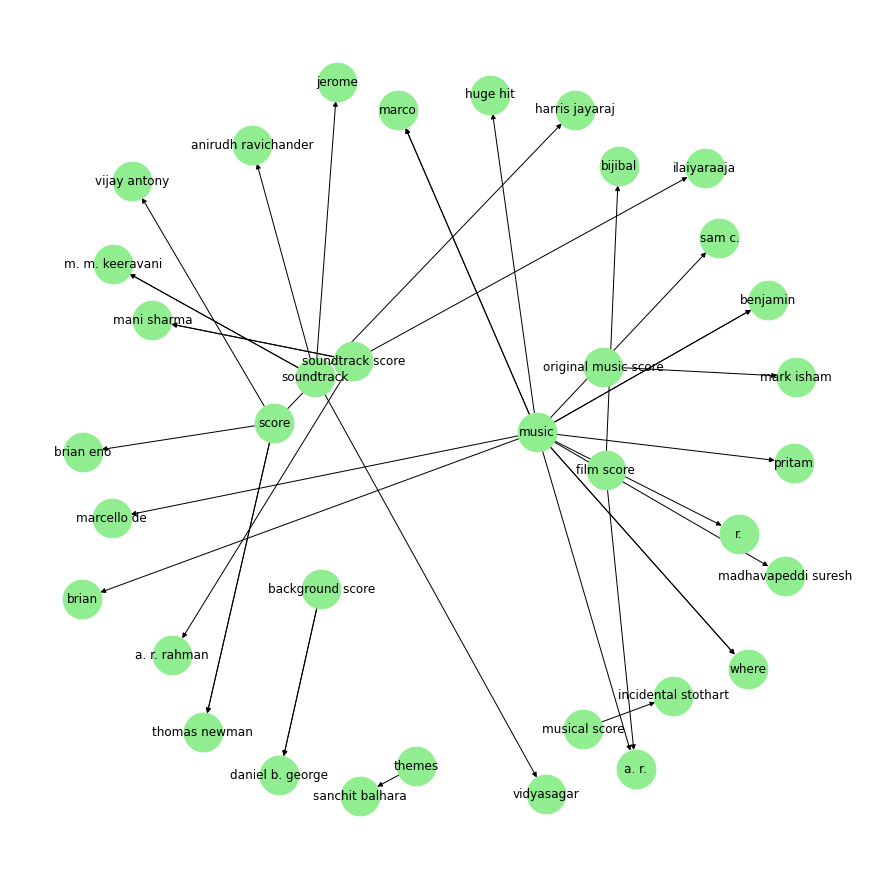

In [ ]:
KG_rel = nx.from_pandas_edgelist(kg_df[kg_df['edge']=="composed by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(KG_rel, k = 0.5) # k regulates the distance between nodes
nx.draw(KG_rel, with_labels=True, node_color='lightgreen', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()